In [126]:
from qiskit import QuantumCircuit, QuantumRegister,Aer, IBMQ, execute,assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit_textbook.tools import array_to_latex
from qiskit.result import marginal_counts

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Load IBM account
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2021-11-03 11:46:36,909: Credentials are already in use. The existing account in the session will be replaced.


## Puertas cuánticas de 1 qubit

Se ilustra el comportamiento teórico de las puertas de Pauli X (o puerta NOT), Y y Z, cuyas matrices se definen como

$$X=\begin{pmatrix} 0 & 1\\ 1 & 0 \end{pmatrix}, \quad Y=\begin{pmatrix} 0 & -i\\ i & 0 \end{pmatrix}, \quad Z=\begin{pmatrix} 1 & 0\\ 0 & -1 \end{pmatrix}.$$

Se crea un circuito de medida con 1 qubit y 1 bit para hacer corresponder los qbits a los bits clásicos 0 y 1. Se añade esta medida a los circuitos creados para cada puerta de Pauli inicializadas en el qubit 0.

In [27]:
# Let's do a measurement circuit with 1 qubit and 1 bit
qc_m = QuantumCircuit(1, 1)
qc_m.measure([0], [0])

/tmp/ipykernel_78/3712920614.py:5: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  qcX += qc_m
/opt/conda/lib/python3.8/site-packages/qiskit/circuit/quantumcircuit.py:942: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)


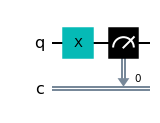

In [3]:
# Let's do an X-gate on a |0> qubit
qcX = QuantumCircuit(1)
qcX.x(0)

qcX += qc_m
qcX.draw('mpl')

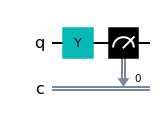

In [8]:
# Let's do an Y-gate on a |0> qubit
qcY = QuantumCircuit(1)
qcY.y(0)

qcY += qc_m
qcY.draw('mpl')

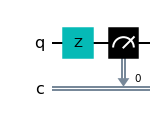

In [9]:
# Let's do an Z-gate on a |0> qubit
qcZ = QuantumCircuit(1)
qcZ.z(0)

qcZ += qc_m
qcZ.draw('mpl')

In [10]:
# Let's use Aer's qasm_simulator
qasm_simulator = Aer.get_backend('qasm_simulator')

# Execute the circuits X,Y and Z on the simulator
job_X = execute(qcX, qasm_simulator, shots=1024)
job_Y = execute(qcY, qasm_simulator, shots=1024)
job_Z = execute(qcZ, qasm_simulator, shots=1024)

# Grab the results from the job and counts
result_X = job_X.result()
result_Y = job_Y.result()
result_Z = job_Z.result()

# Counts the results
counts_X = result_X.get_counts(qcX)
counts_Y = result_Y.get_counts(qcY)
counts_Z = result_Z.get_counts(qcZ)

Las salidas correspondientes para cada puerta de Pauli deben ser:

$$X|0\rangle=\begin{pmatrix} 0 & 1\\ 1 & 0 \end{pmatrix}\begin{pmatrix} 1\\ 0\end{pmatrix} = \begin{pmatrix}0\\ 1\end{pmatrix}=|1\rangle.$$

$$Y|0\rangle=\begin{pmatrix} 0 & -i\\ i & 0 \end{pmatrix}\begin{pmatrix} 1\\ 0\end{pmatrix} = \begin{pmatrix}0\\ i\end{pmatrix}=i|1\rangle.$$

$$Z|0\rangle=\begin{pmatrix} 1 & 0\\ 0 & -1 \end{pmatrix}\begin{pmatrix} 1\\ 0\end{pmatrix} = \begin{pmatrix}1\\ 0\end{pmatrix}=|1\rangle.$$

Es decir, se obtendrá el qubit $|1\rangle$ en las puertas X, Y y Z con probabilidad $|1|^2=1$, $|i|^2=1$ y $|1|^2=1$ respectivamente. 

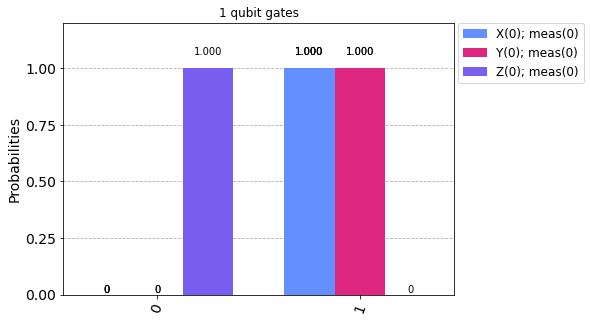

In [22]:
plot_histogram([counts_X,counts_Y,counts_Z], title="1 qubit gates", legend=['X(0); meas(0)', 'Y(0); meas(0)', 'Z(0); meas(0)'],)

## Puertas cuánticas de 2 qbits

### CNOT

En este caso se prueba la puerta $C_X$ o CNOT, la cual opera sobre 2 qbits y aplica un NOT al qubit objetivo si el qubit de control toma el valor $|1\rangle$. En esta puerta consideramos que el qubit de control es $q_0$. 

La matriz que representa la puerta $C_X$ es

$$C_X=\begin{pmatrix}1 & 0 & 0 & 0\\ 0 & 0 & 0 & 1\\ 0 & 0 & 1 & 0\\ 0 & 1 & 0 & 0\end{pmatrix}.$$

y

$$C_X|00\rangle=\begin{pmatrix}1 & 0 & 0 & 0\\ 0 & 1 & 0 & 0\\ 0 & 0 & 0 & 1\\ 0 & 0 & 1 & 0\end{pmatrix}\begin{pmatrix}1\\0\\0\\0\end{pmatrix}=\begin{pmatrix}1\\0\\0\\0\end{pmatrix}=|00\rangle$$


In [132]:
qc_m = QuantumCircuit(2, 2)
qc_m.measure([0,1], [0,1])

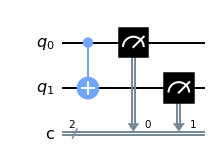

In [133]:
qcCX = QuantumCircuit(2)
qcCX.cx(0, 1)
qcCX += qc_m
qcCX.draw('mpl')

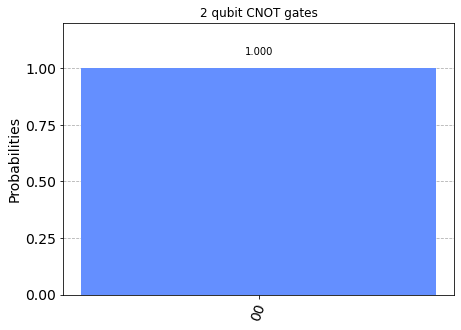

In [137]:
ibmq_qasm_simulator = provider.get_backend('ibmq_qasm_simulator')

job_CX = execute(qcCX, ibmq_qasm_simulator, shots=1024)
result_CX = job_CX.result()
counts_CX = result_CX.get_counts(qcCX)

plot_histogram(counts_CX, title="2 qubit CNOT gates")

## Generación de números aleatorios


Utilizando puertas Hadamard, se implementa un generador de números aleatorios de 8 bits. 

Para ello, se utilizan 8 qbits en superposición y se realizan las mediciones de cada qubit, de manera que cada qubit colapsará a 0 o 1 con la misma probabilidad. Por tanto, si representamos el histograma después de $1024·8=8192$ ejecuciones se espera que los $2^8=256$ posibles valores aparezan unas $8192/256=32$ veces.

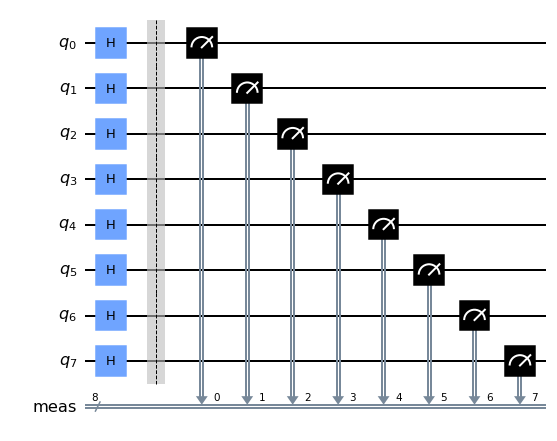

In [68]:
qcR = QuantumCircuit(8)
qcR.h(QuantumRegister(8, 'q')) # Apply Hadamard gate to all qbits
qcR.measure_all()
qcR.draw('mpl')

In [71]:
job_R = execute(qcR, qasm_simulator, shots=8192)
result_R = job_R.result()
counts_R = job_R.result().get_counts(qcR)

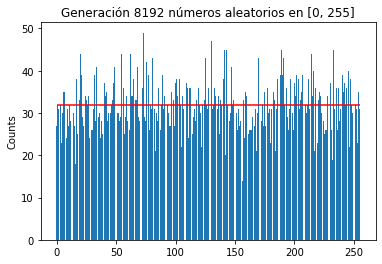

In [104]:
counts =  counts_R.values()
values = range(len(counts))
plt.bar(values,counts)
plt.hlines(32,0,255, color = 'r')
plt.title("Generación 8192 números aleatorios en [0, 255]")
plt.ylabel("Counts")
plt.show()

## Entrelazamiento

Se comprueba el comportamiento del circuito descrito abajo y se explica por qué el resultado es una función de onda entrelazada.

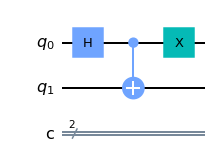

In [121]:
qc = QuantumCircuit(2, 2)
qc.h(0)
qc.cx(0, 1)
qc.x(0)

qc.draw(output='mpl')

Dos qbits se encuentran entrelazados cuando el sistema toma valor  $\frac{1}{\sqrt{2}}(|10\rangle-|01\rangle)$, es decir, toma el valor $|10\rangle$ con probabilidad $\frac{1}{2}$ y el valor $|01\rangle$ con probabilidad $\frac{1}{2}$, mientras que tiene un $0\%$ de probabilidad de medirse en los estados $|00\rangle$ y $|11\rangle$. 

Para este tipo de sistemas, observando el estado de un qubit puedo conocer el estado del otro al que está entrelazado sin necesidad de medir el segundo. ya que si el primer qubit resulta ser $|0\rangle$, el segundo necesariamente será $|1\rangle$, y viceversa.

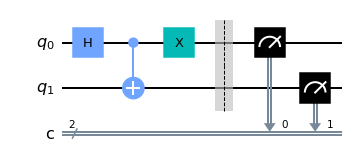

In [122]:
qc.barrier()
qc.measure([0,1], [0,1])
qc.draw(output='mpl')

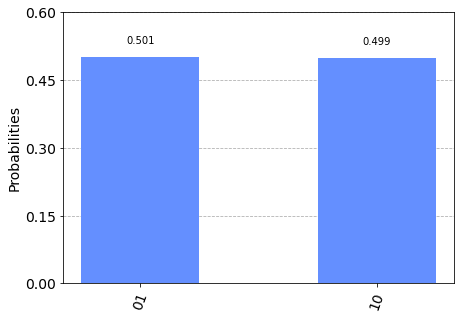

In [130]:
ibmq_qasm_simulator = provider.get_backend('ibmq_qasm_simulator')
result = execute(qc, ibmq_qasm_simulator, shots=1024).result()
counts = result.get_counts(qc)
plot_histogram(counts)

Viendo los resultados del histograma, podemos concluir que el resultado del circuito es un entrelazamiento, ya se exhiben correlaciones.

## Sumador de 2 qbits

https://qiskit.org/textbook/ch-states/atoms-computation.html

$$
\begin{tabular}{ |c|c|c| } 
 \hline
 0 & 0 & 00 \\ 
 0 & 1 & 01 \\ 
 1 & 0 & 01 \\ 
 1 & 1 & 10 \\ 
 \hline
\end{tabular}
$$


In [145]:
def QuantumCircuitSum(a, b):
    qc_ha = QuantumCircuit(4,2)
    if a == 1:
        qc_ha.x(0)
    if b == 1:
        qc_ha.x(1)
    qc_ha.barrier()
    # use cnots to write the XOR of the inputs on qubit 2
    qc_ha.cx(0,2)
    qc_ha.cx(1,2)
    # use ccx to write the AND of the inputs on qubit 3
    qc_ha.ccx(0,1,3)
    qc_ha.barrier()
    # extract outputs
    qc_ha.measure(2,0) # extract XOR value
    qc_ha.measure(3,1) # extract AND value
    return qc_ha

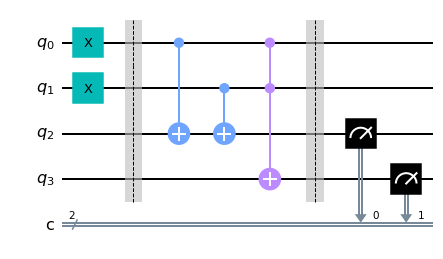

In [ ]:
qc_ha_00 = QuantumCircuitSum(0,0)
qc_ha_01 = QuantumCircuitSum(0,1)
qc_ha_10 = QuantumCircuitSum(1,0)
qc_ha_11 = QuantumCircuitSum(1,1)

#example draw
qc_ha_11.draw()

A continuación, se explica el circuito representado arriba.

Las líneas discontinuas en la imagen son solo para distinguir las diferentes partes del circuito.


# ESCRIBIR


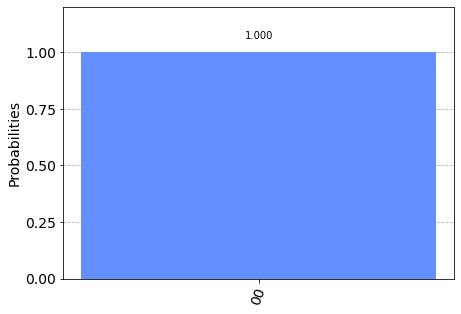

In [157]:
# 0+0
aer_simulator = Aer.get_backend('aer_simulator') 

qobj = assemble(qc_ha_00)
counts = aer_simulator.run(qobj).result().get_counts()
plot_histogram(counts)

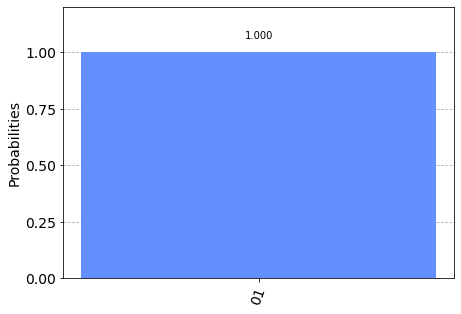

In [160]:
# 1+0
aer_simulator = Aer.get_backend('aer_simulator') 

qobj = assemble(qc_ha_10)
counts = aer_simulator.run(qobj).result().get_counts()
plot_histogram(counts)

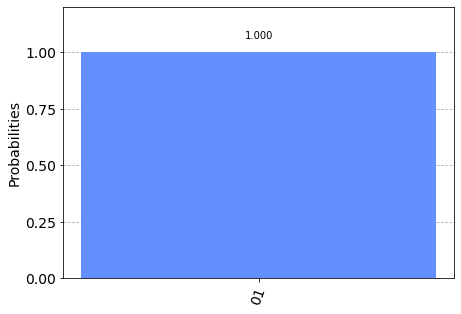

In [159]:
# 0+1
aer_simulator = Aer.get_backend('aer_simulator') 

qobj = assemble(qc_ha_01)
counts = aer_simulator.run(qobj).result().get_counts()
plot_histogram(counts)

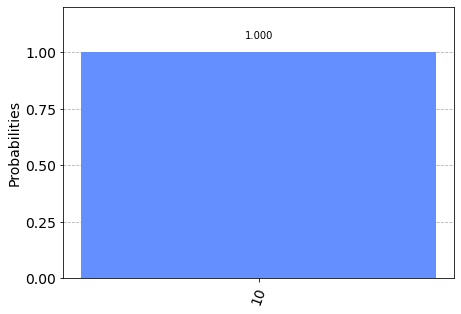

In [161]:
# 1+1
aer_simulator = Aer.get_backend('aer_simulator') 

qobj = assemble(qc_ha_11)
counts = aer_simulator.run(qobj).result().get_counts()
plot_histogram(counts)

# ALGORITMOS CUÁNTICOS
https://qiskit.org/textbook/ch-algorithms/grover.html

https://qiskit.org/textbook/ch-algorithms/teleportation.html

https://qiskit.org/textbook/ch-algorithms/bernstein-vazirani.html